In [217]:
import os
import random
from datetime import datetime
import ast

import gc
import yaml
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch.utils.tensorboard import SummaryWriter

from preprocessing.default_preprocessing import serve_data
from models.transformer_encoder import TransEncoder
from models.baseline import BaseLineModel
from ddpm import GaussianDiffusion1D
from evaluation.pca_tsne import visualize_pca_tsne
from evaluation.jsd import compute_jsd

random.seed(42)
np.random.seed(42)

In [218]:
if torch.cuda.is_available():
    torch.cuda.empty_cache()
gc.collect()

4371

# Parameters

In [219]:
config_path = "./config.yml"
with open(config_path, 'r') as f:
    config = yaml.full_load(f)

date = datetime.today().strftime('%Y-%m-%d-%H-%M')
device = 'cuda' if torch.cuda.is_available() else 'cpu'

seq_len = config["seq_len"]
epochs = config["epochs"]
timesteps = config["timesteps"]
batch_size_config = config["batch_size"]
latent_dim = config["latent_dim"]
num_layers = config["num_layers"]
n_heads = config["n_heads"]
beta_schedule = config["beta_schedule"]
objective = config["objective"]
subset_len = config["subset_len"]
model_name = config["model_name"]
cond_model = config["cond_model"]
lr = float(config["lr"])
betas = tuple_of_floats = ast.literal_eval(config["betas"])
save_rate = int(config["save_rate"])

assert model_name in ["BaseLine", "TransEncoder"], "Chosen  model was not valid, the options are BaseLine, TransEncoder and"
assert cond_model in {"mlp", "te", "stft"}, "Chosen conditioning model was not valid, the options are mlp, te and stft"

log_file_name = f"{model_name}_{cond_model}_{str(date)}"
tb_writer = f"./logging/tensorboard/{log_file_name}"


# Data

In [220]:
train_loader, test_loader, features, cond_features = serve_data(seq_len, batch_size_config, subset_len)

num of channels in transformer: 1 
num of cond feature: 3
Train shape (batch, features, seq_len): (33855, 1, 15)
Cond shape (batch, features, seq_len): (33855, 3, 15)
batched data shape: torch.Size([64, 1, 15])


# Model

In [221]:
if model_name == "TransEncoder":
    model = model = TransEncoder(features = features, latent_dim = latent_dim,num_heads = n_heads, num_layers = num_layers, cond_features=cond_features, cond_model=cond_model, device=device)
if model_name == "BaseLine":
    model = BaseLineModel(input_size=seq_len, hidden_size=latent_dim, cond_features=cond_features, cond_model=cond_model, device=device)
    
ddpm = GaussianDiffusion1D(model, seq_length = seq_len, timesteps = timesteps, objective = objective, loss_type = 'l2', beta_schedule = beta_schedule)
ddpm = ddpm.to(device)

optim = torch.optim.Adam(ddpm.parameters(), lr = lr, betas = betas)
writer = SummaryWriter(tb_writer)

c:\Users\Arne\anaconda3\envs\hf_diff\lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


## Train

In [222]:
run_path = f"./logging/weights/{log_file_name}"
os.makedirs(run_path)

lowest_loss = 100000
step=0
for running_epoch in tqdm(range(epochs)):
    for i, (data, cond_data) in enumerate(train_loader):
        data = data.to(device)
        
        cond_data = cond_data.float()
        cond_data = cond_data.to(device)
        
        batch_size = data.shape[0]
        
        optim.zero_grad()

        loss = ddpm(data, cond_data)
        loss.backward()
        
        optim.step()
        
        if loss.item() < lowest_loss:
            lowest_loss = loss.item()
            best_model_params = model.state_dict()
        
        writer.add_scalar("Training Loss", loss, global_step=step)
        step += 1
        
    if i%len(train_loader)== 0 and running_epoch%10==0:
        print(f'Epoch: {running_epoch+1}, Loss: {loss.item()}')

    if running_epoch % save_rate == 0:
        torch.save({
            'epoch': running_epoch+1,
            'diffusion_state_dict': ddpm.state_dict(),
            'diffusion_optim_state_dict': optim.state_dict()
            }, os.path.join(f'{run_path}', f'{running_epoch}_weights.pth'))

torch.save(best_model_params, os.path.join(f'{run_path}', 'best_model_weights.pth'))

 25%|██▌       | 1/4 [00:10<00:32, 10.91s/it]

True
0
2


 50%|█████     | 2/4 [00:21<00:21, 10.90s/it]

False
1
2


 75%|███████▌  | 3/4 [00:32<00:10, 10.92s/it]

True
2
2


100%|██████████| 4/4 [00:43<00:00, 10.99s/it]

False
3
2


## Sampling

In [223]:
with torch.no_grad():
    samples = ddpm.sample(batch_size_config)
    samples = samples.cpu().numpy()
    samples = samples.transpose(0, 2, 1)

print(f"Samples shape: {samples.shape}")

sampling loop time step: 100%|██████████| 1000/1000 [00:02<00:00, 344.71it/s]

Samples shape: (64, 15, 1)


# Evaluation
## Without Conditioning

In [224]:
real_data_train, real_cond_data_train = next(iter(train_loader))
real_data_test, real_cond_data_test = next(iter(test_loader))

real_cond_data_train.shape, real_data_test.shape

(torch.Size([64, 3, 15]), torch.Size([64, 1, 15]))

### T-SNE and PCA

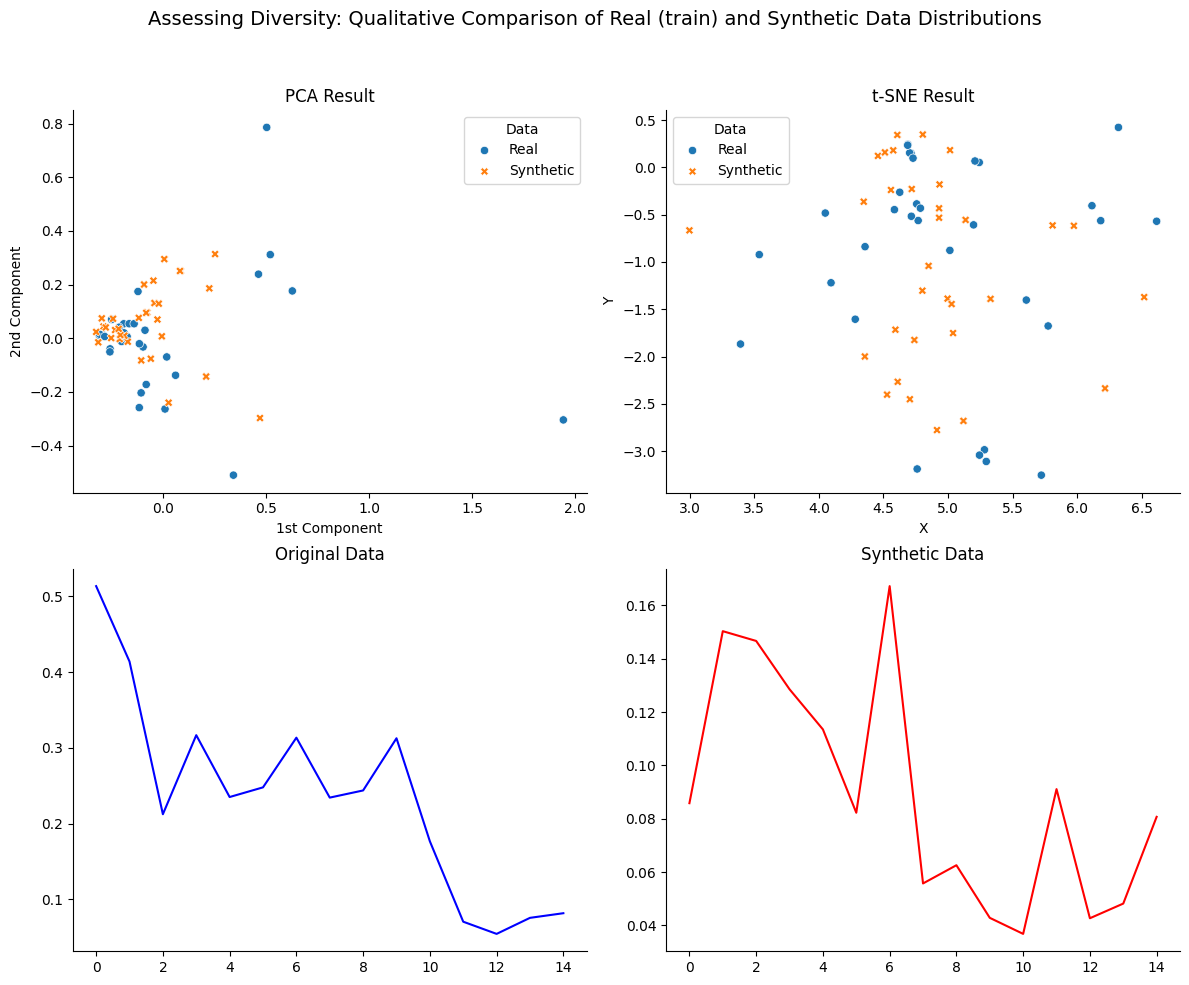

In [225]:
visualize_pca_tsne(ori_data=real_data_train.cpu().numpy().transpose(0,2,1), fake_data=samples, seq_len=seq_len, train_test="train", filename=log_file_name, cond=False)

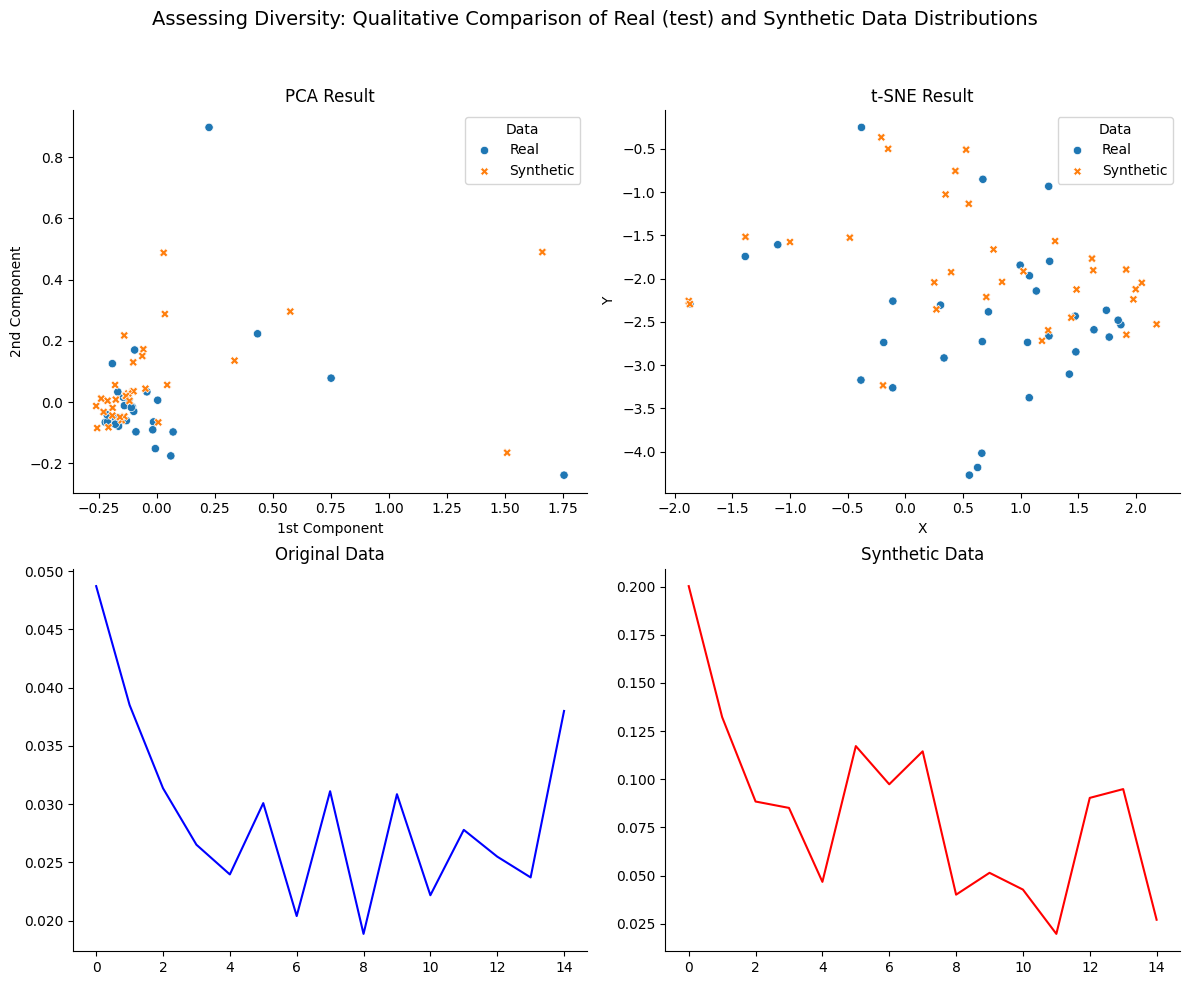

In [226]:
visualize_pca_tsne(ori_data=real_data_test.cpu().numpy().transpose(0,2,1), fake_data=samples, seq_len=seq_len, train_test="test", filename=log_file_name, cond=False)

### Jensen-Shannon Divergence

In [227]:
jsd_no_con_train = compute_jsd(real_data_train, samples)
jsd_no_con_test = compute_jsd(real_data_test, samples)

jsd_no_con_train, jsd_no_con_test

(0.30398500370899234, 0.3359000454032291)

## With Conditioning

In [228]:
with torch.no_grad():
    cond_samples_train = ddpm.sample(real_cond_data_train.shape[0], real_cond_data_train.to(device))
    cond_samples_train = cond_samples_train.cpu().numpy()
    cond_samples_train = cond_samples_train.transpose(0, 2, 1)

print(f"Samples shape: {cond_samples_train.shape}")

sampling loop time step: 100%|██████████| 1000/1000 [00:05<00:00, 175.37it/s]

Samples shape: (64, 15, 1)


### T-SNE and PCA

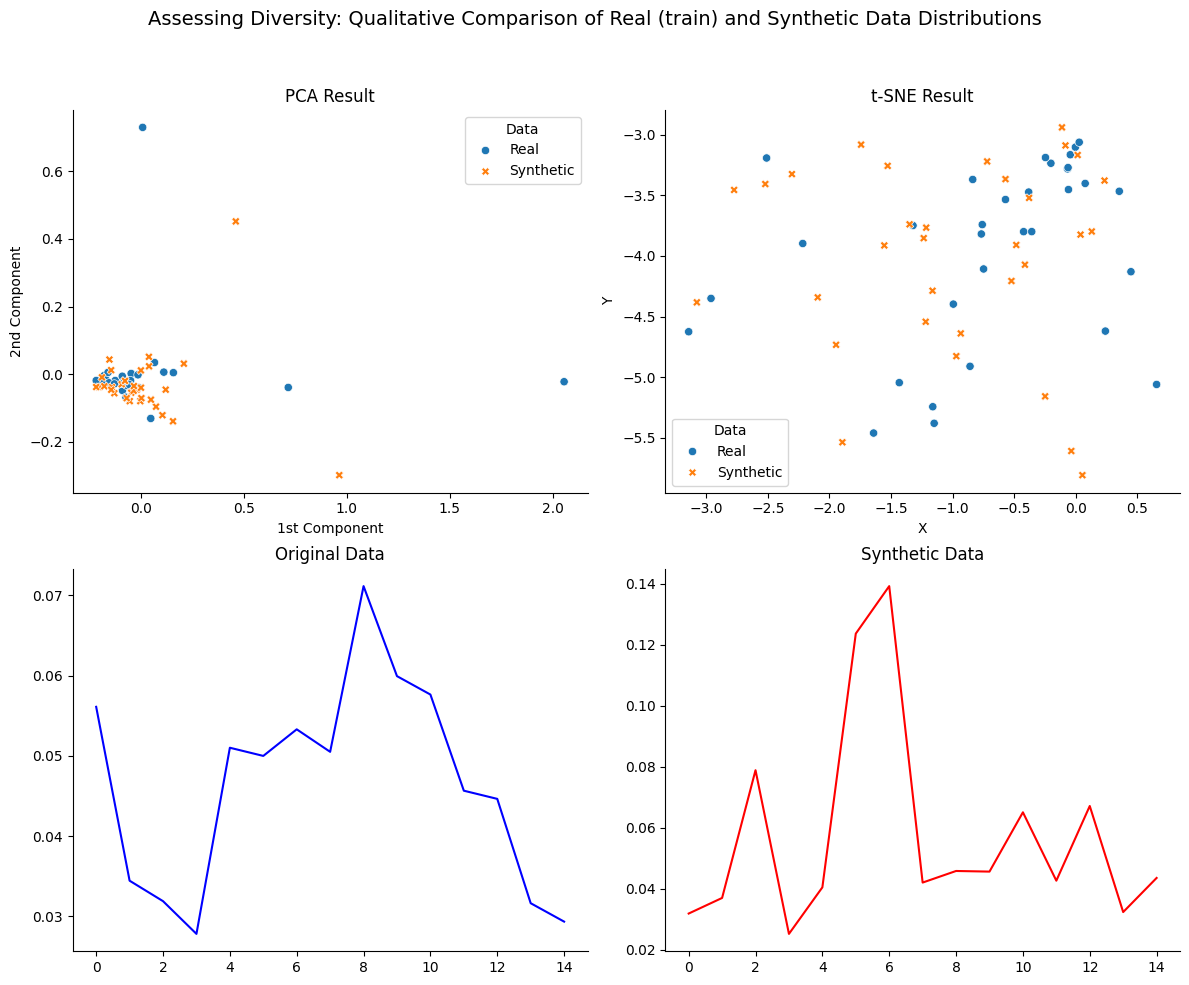

In [229]:
visualize_pca_tsne(ori_data=real_data_train.cpu().numpy().transpose(0,2,1), fake_data=cond_samples_train, seq_len=seq_len, train_test="train", filename=log_file_name, cond=True)

In [230]:
with torch.no_grad():
    cond_samples_test = ddpm.sample(real_cond_data_test.shape[0], real_cond_data_test.to(device))
    cond_samples_test = cond_samples_test.cpu().numpy()
    cond_samples_test = cond_samples_test.transpose(0, 2, 1)

print(f"Samples shape: {cond_samples_test.shape}")

sampling loop time step: 100%|██████████| 1000/1000 [00:05<00:00, 181.63it/s]

Samples shape: (64, 15, 1)


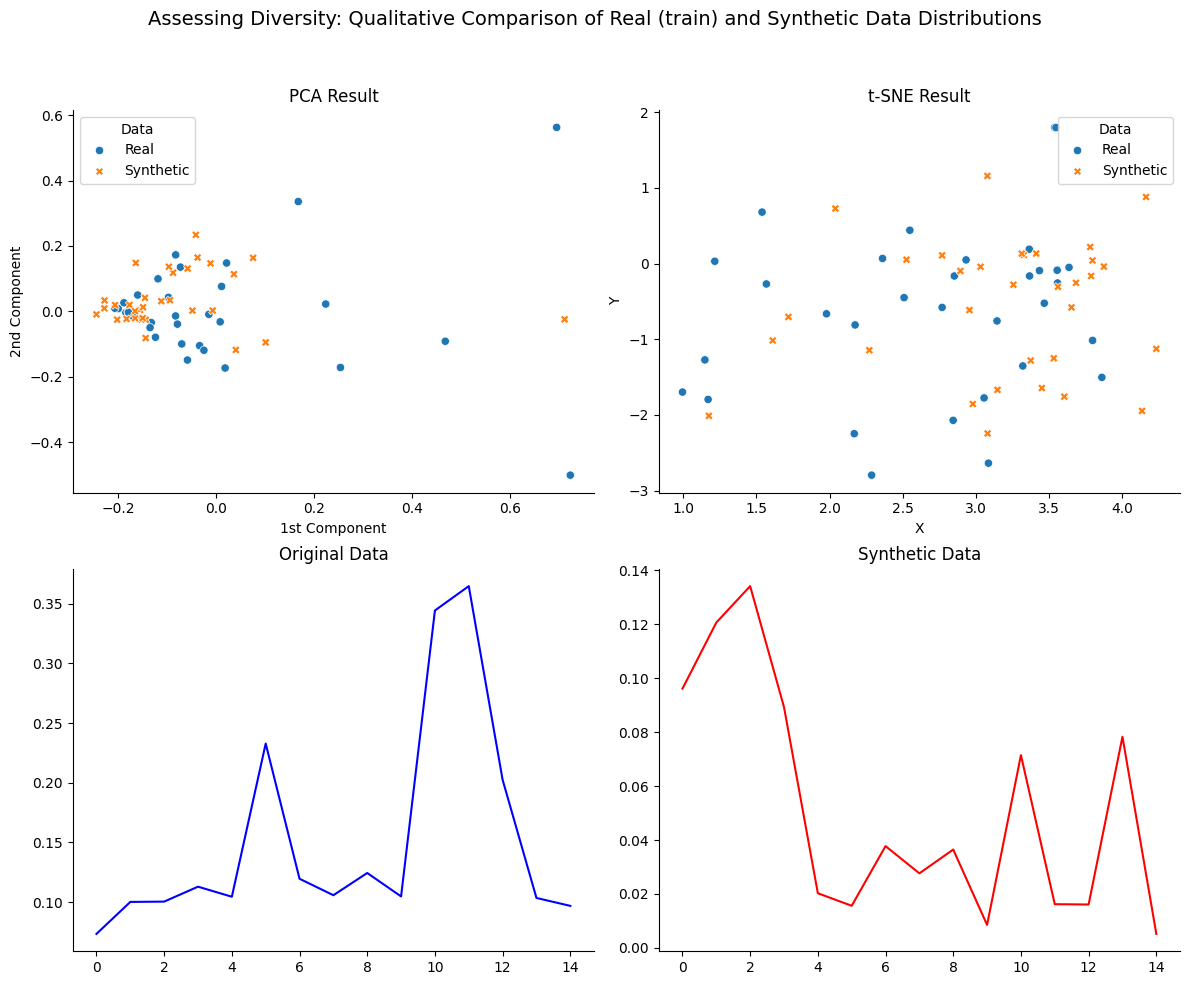

In [231]:
visualize_pca_tsne(ori_data=real_data_test.cpu().numpy().transpose(0,2,1), fake_data=cond_samples_test, seq_len=seq_len, train_test="train", filename=log_file_name, cond=True)

### Jensen-Shannon Divergence

In [232]:
jsd_con_train = compute_jsd(real_data_train, cond_samples_train)
jsd_con_test = compute_jsd(real_data_test, cond_samples_test)

jsd_con_train, jsd_con_test

(0.26223791652445966, 0.44664751607707964)

## Viz

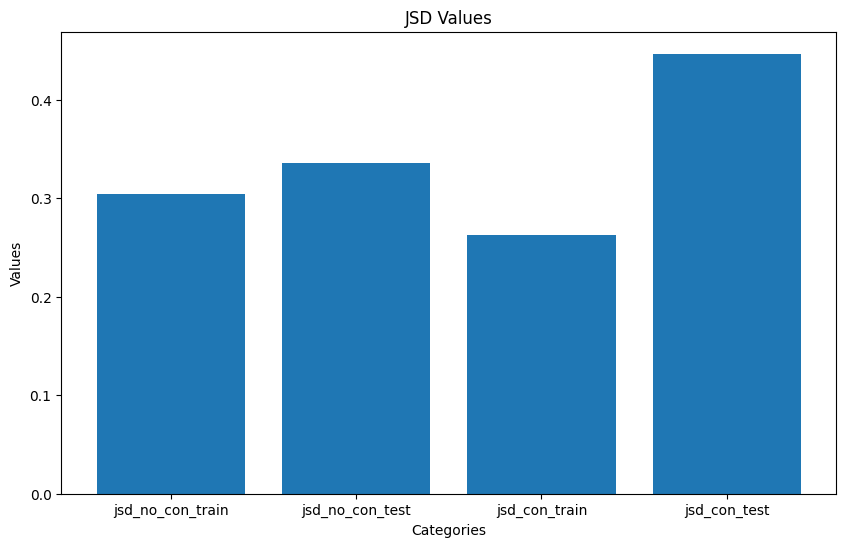

In [233]:
jsd = {
    "jsd_no_con_train": jsd_no_con_train, 
    "jsd_no_con_test": jsd_no_con_test,
    "jsd_con_train": jsd_con_train, 
    "jsd_con_test": jsd_con_test
}

labels = list(jsd.keys())
values = list(jsd.values())

plt.figure(figsize=(10, 6))
plt.bar(labels, values)

plt.title('JSD Values')
plt.xlabel('Categories')
plt.ylabel('Values')

plt.show()

# Logging

In [234]:
log_dir = "./logging/logs"
log_file_path = os.path.join(log_dir, log_file_name + ".txt")

with open(log_file_path, 'w') as log_file:
    log_file.write("Config:\n")
    for key, value in config.items():
        log_file.write(f"{key}: {value}\n")
    
    log_file.write("\nJSD Values:\n")
    for key, value in jsd.items():
        log_file.write(f"{key}: {value}\n")

print(f"Log file created at: {log_file_path}")

Log file created at: ./logging/logs\TransEncoder_te_2025-02-19-19-39.txt


In [237]:
best_model = torch.load("./logging/weights/TransEncoder_te_2025-02-19-19-39/best_model_weights.pth")

C:\Users\Arne\AppData\Local\Temp\ipykernel_2804\96976265.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model = torch.load("./logging/weights/TransEncoder_te_2025-